# Overview:

Done:

* Able to get the neuron_output
* Training

To-do:

* for AlexNet, the filter size, stridel, padding size change across different layers --> need to address this?
* pre-trained = True --> is this correct? 
* check if *list method is correct 

References:

https://deeplearning.neuromatch.io/projects/Neuroscience/blurry_vision.html?highlight=alexnet

https://www.kaggle.com/asilvaigor/learning-alexnet

https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy

https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3?u=klory

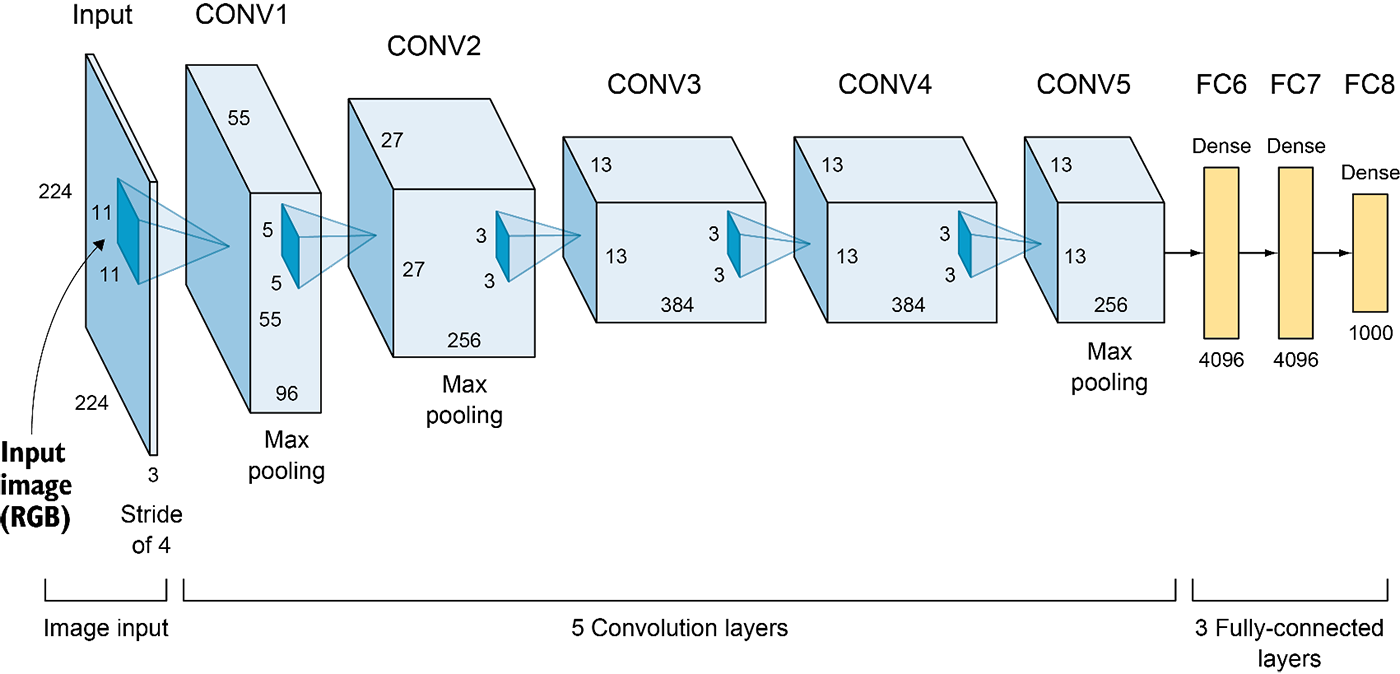

In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.7.0
numpy Version: 1.19.5


In [2]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time

In [4]:
print(torch.__version__)

1.10.0+cu111


In [5]:
print(torchvision.__version__)

0.11.1+cu111


# Loading CIFAR-10 data:

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_data[1][0]

tensor([[[ 0.1083,  0.0569,  0.0056,  ..., -0.6794, -0.7137, -0.7479],
         [ 0.0912,  0.0398, -0.0116,  ..., -0.7137, -0.7479, -0.7822],
         [ 0.0741,  0.0227, -0.0287,  ..., -0.7479, -0.7650, -0.7993],
         ...,
         [ 0.5536,  0.5536,  0.5364,  ..., -1.1418, -1.1075, -1.0562],
         [ 0.5536,  0.5536,  0.5364,  ..., -1.0048, -0.9705, -0.9363],
         [ 0.5536,  0.5536,  0.5536,  ..., -0.8678, -0.8335, -0.7993]],

        [[ 0.2927,  0.2227,  0.1527,  ..., -0.5126, -0.5476, -0.5826],
         [ 0.2752,  0.2052,  0.1352,  ..., -0.5476, -0.5826, -0.6176],
         [ 0.2577,  0.1877,  0.1176,  ..., -0.5826, -0.6176, -0.6352],
         ...,
         [ 0.7129,  0.7304,  0.7479,  ..., -1.1779, -1.1429, -1.1078],
         [ 0.7129,  0.7304,  0.7479,  ..., -1.0553, -1.0028, -0.9678],
         [ 0.7129,  0.7304,  0.7479,  ..., -0.9153, -0.8803, -0.8452]],

        [[ 0.4788,  0.3916,  0.3219,  ..., -0.6193, -0.6541, -0.6715],
         [ 0.4614,  0.3916,  0.3045,  ..., -0

In [9]:

N_train = 50000
N_test = 10000
img_shape = (32, 32, 3) #use a tuple in the fomat: (height, width, n_channels)
n_classes = 10
print(N_train,N_test,img_shape,n_classes)

50000 10000 (32, 32, 3) 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


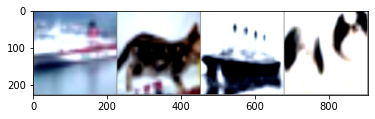

 Ship   Cat  Ship   Dog


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Training AlexNet:

In [11]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

In [12]:
AlexNet_Model = AlexNet(num_classes=10, downscale=2)
AlexNet_Model.eval()

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [13]:
# AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

In [14]:
# import torch.nn as nn
# AlexNet_Model.classifier[1] = nn.Linear(9216,4096)
# AlexNet_Model.classifier[4] = nn.Linear(4096,1024)
# AlexNet_Model.classifier[6] = nn.Linear(1024,10)

In [15]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, 11, stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(64, 192, 5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(192, 384, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x
# from torch.utils import model_zoo
# def alexnet_classifier(num_classes):
#     classifier = nn.Sequential(
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(9216,4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(4096,1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024,num_classes),
#             nn.Softmax(),
#         )
#     return classifier

# def alexnet(num_classes, pretrained=False, **kwargs):
#     """AlexNet model architecture from the
#     `"One weird trick..." `_ paper.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = AlexNet(**kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'))
#         for p in model.features.parameters():
#             p.requires_grad=False
#     classifier = alexnet_classifier(num_classes)
#     model.classifier = classifier
#     return model
# model = alexnet(10, True)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
print(device)

cuda:0


In [19]:
AlexNet_Model.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [20]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 1')

[1,  2000] loss: 2.162
Time: 39.391961097717285
[1,  4000] loss: 1.848
Time: 80.33890652656555
[1,  6000] loss: 1.613
Time: 119.77165174484253
[1,  8000] loss: 1.484
Time: 159.58222794532776
[1, 10000] loss: 1.363
Time: 198.70728302001953
[1, 12000] loss: 1.281
Time: 237.78863787651062
Finished Training of AlexNet: Epoch 1


# Visualizing filters:

In [21]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

torch.Size([32, 3, 11, 11])
(54, 106, 3)


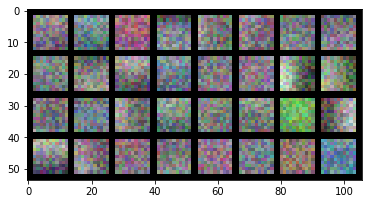

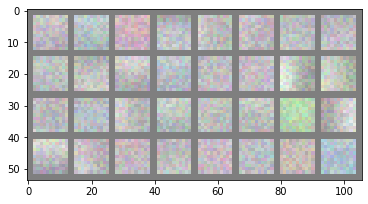

In [22]:
show_weights(AlexNet_Model.conv_layer1)

# Visualizing outputs given an image: 

In [23]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


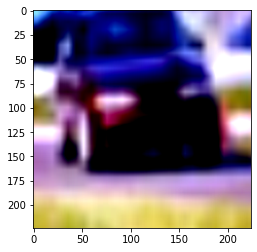

In [24]:
imshow(images[0])

In [25]:
images = images.type(torch.cuda.FloatTensor)
im = images[0]
im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))

In [26]:
# def plot_intermediate_layers(image, net, return_layers):
#   # Get output for the image from the intermediate layers
#   intermediate_output = LayerGetter(net, return_layers=return_layers)(image)
#   fig = plt.figure(figsize=(12, 3))
#   ax=fig.add_subplot(141)
#   ax.imshow(image.squeeze(0).permute(1, 2, 0))
#   plt.axis('off')
#   plt.title('Original Image')
#   ax=fig.add_subplot(142)
#   ax.imshow(intermediate_output[0]['v1'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V1 layer (Average)')
#   ax=fig.add_subplot(143)
#   ax.imshow(intermediate_output[0]['v2'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V2 layer (Average)')
#   ax=fig.add_subplot(144)
#   ax.imshow(intermediate_output[0]['v4'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V4 layer (Average)')
#   plt.show()

In [27]:
!pip install torch_intermediate_layer_getter

In [28]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

torch.Size([1, 192, 13, 13])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

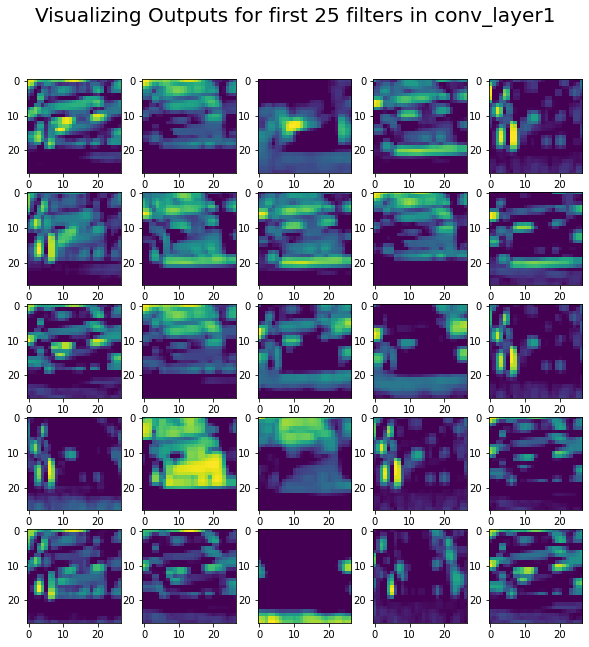

In [29]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer3')

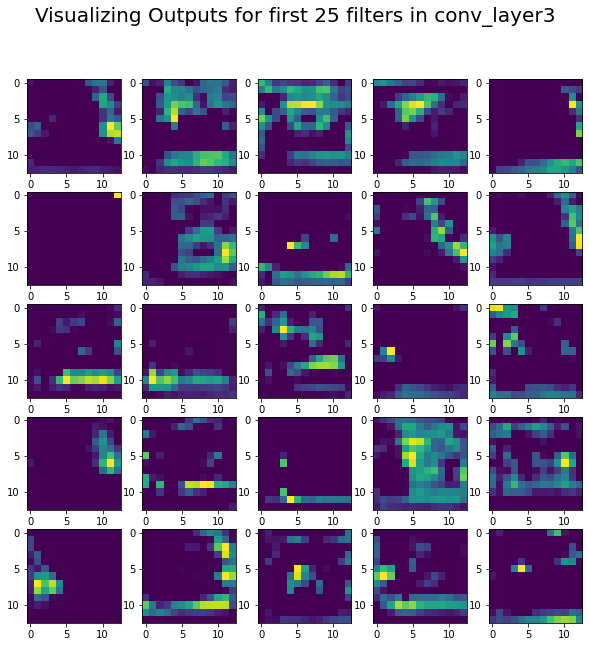

In [30]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer5')

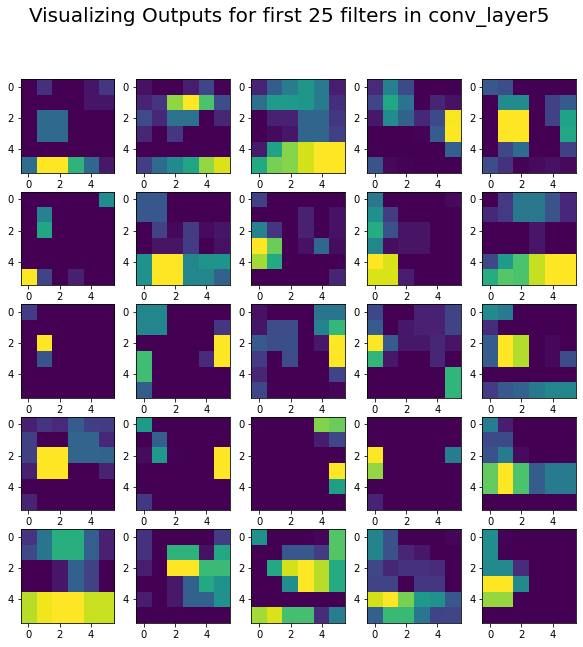

In [31]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)

In [32]:
f = torch.nn.Sequential(*list(AlexNet_Model.children())[:-23])
feature_outputs = f(im)

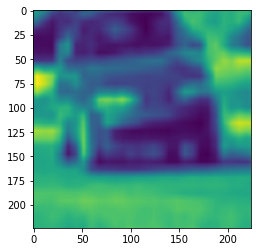

In [33]:
plt.imshow(feature_outputs[0,0,:,:].cpu().data)

In [34]:
f = torch.nn.Sequential(*list(AlexNet_Model.children())[:-15])
feature_outputs = f(im)

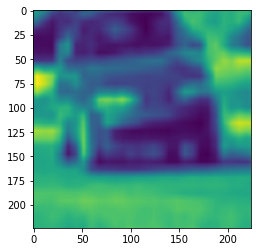

In [35]:
plt.imshow(feature_outputs[0,0,:,:].cpu().data)

# Visualizing embeddings:

In [36]:
AlexNet_Model.children()

<generator object Module.children at 0x7fd22065fb50>

In [37]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        im, an image of shape (im_size, im_size, 3)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[0]
    im_size_horizontal = im.shape[1]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=0)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=1)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

In [38]:
def compute_neuron_output_alt(layer_names, images, plot_activity = False):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        images: an array of images (stimuli)
    return:
        
    '''
    n_images = 40
    n_layers = len(layer_names)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    images = images.type(torch.cuda.FloatTensor)
    
    layer_index = 1
    for layer_name in layer_names:
        ## note: always take the images as inputs
        return_layers = {layer_name: layer_name}
        LayerGetter = torchvision.models._utils.IntermediateLayerGetter(AlexNet_Model, return_layers=return_layers)
        neuron_output = []
        for i in range(n_images):
          im = images[i]
          im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
          output = LayerGetter(im)
          output = output[layer_name] 
          neuron_output.append(output)
        neuron_output =  torch.stack(neuron_output)
        neuron_output = neuron_output.reshape((neuron_output.shape[0], neuron_output.shape[2], neuron_output.shape[3], neuron_output.shape[4]))

        neuron_output = neuron_output.permute(0, 2, 3, 1)
        
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
        neuron_output = neuron_output[:,2:(n_row-2),2:(n_col-2),:]
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        neuron_output = neuron_output.reshape((n_images, n_row * n_col, n_feature_maps))
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.permute(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    fm_avg_all_layers = fm_avg_all_layers.cpu().data
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers.cpu().data
    
    for i in range(n_images):
        max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

    for i in range(10):    
        neuron_labels += [i] * n_neurons
          
    neuron_labels = np.array(neuron_labels)     
    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

In [39]:
def show_stimuli(layer_names, images_selected_classes, shifts, plot_activity = False):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    
    # images_selected_classes = np.array(images_selected_classes)
    n_images = 40

    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, images_selected_classes, plot_activity = plot_activity)
    
    else:
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, 1)
            im_all_shifts = torch.Tensor(im_all_shifts)
            neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, im_all_shifts, plot_activity = False)
            ## neuron_output_highest is of shape (number of shifts, neurons)

            ## take the average over all shifts of im
            shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
            shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
            
            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                neuron_output_highest_with_shifts = shifts_avg 
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                
        neuron_output_highest = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels

Take 40 images, 10 images each in the airplane, automobile, cat, dog classes:

In [40]:
airplane_indices, automobile_indices, cat_indices, dog_indices = [], [], [], []
airplane_idx, automobile_idx, cat_idx, dog_idx = train_data.class_to_idx['airplane'], train_data.class_to_idx['automobile'], train_data.class_to_idx['cat'], train_data.class_to_idx['dog']

i = 0
while(len(airplane_indices) < 10 or len(automobile_indices) < 10 or len(cat_indices) < 10 or len(dog_indices) < 10):
  current_class = train_data[i][1]
  if current_class == airplane_idx:
    airplane_indices.append(i)
  elif current_class == automobile_idx:
    automobile_indices.append(i)
  elif current_class == cat_idx:
    cat_indices.append(i)
  elif current_class == dog_idx:
    dog_indices.append(i)
  i += 1

airplane_indices = airplane_indices[0:10]
automobile_indices = automobile_indices[0:10]
cat_indices = cat_indices[0:10]
dog_indices = dog_indices[0:10]
selected_train_data = Subset(train_data, airplane_indices + automobile_indices + cat_indices + dog_indices)
n_images = 40

In [41]:
# get some random training images
trainloader_images_selected_classes = torch.utils.data.DataLoader(selected_train_data, batch_size=n_images, shuffle=True, num_workers=2)
dataiter_images_selected_classes = iter(trainloader_images_selected_classes)
images_selected_classes, labels_selected_classes = dataiter_images_selected_classes.next()

In [42]:
images_selected_classes.shape

torch.Size([40, 3, 224, 224])

In [43]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer2'], images_selected_classes, shifts = True)

In [44]:
from sklearn.decomposition import PCA
pca = PCA(10)
neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
neuron_output_highest_with_shifts_projected.shape

(810, 10)

In [45]:
print(neuron_labels.shape)

(810,)


In [46]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 81
1 81
2 81
3 81
4 81
5 81
6 81
7 81
8 81
9 81


In [47]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
pca = PCA(10)
neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
neuron_output_highest_with_shifts_projected.shape
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# More epochs:

In [80]:
for epoch in range(9):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 10')

[1,  2000] loss: 1.124
Time: 51.025566816329956
[1,  4000] loss: 1.103
Time: 101.23776984214783
[1,  6000] loss: 1.018
Time: 151.26592707633972
[1,  8000] loss: 0.956
Time: 201.39403986930847
[1, 10000] loss: 0.923
Time: 251.47362732887268
[1, 12000] loss: 0.877
Time: 301.66110038757324
[2,  2000] loss: 0.735
Time: 46.698365211486816
[2,  4000] loss: 0.719
Time: 93.05128622055054
[2,  6000] loss: 0.725
Time: 139.60140776634216
[2,  8000] loss: 0.688
Time: 186.01350045204163
[2, 10000] loss: 0.704
Time: 232.3998589515686
[2, 12000] loss: 0.695
Time: 278.9676365852356
[3,  2000] loss: 0.510
Time: 46.32772874832153
[3,  4000] loss: 0.505
Time: 92.60881757736206
[3,  6000] loss: 0.527
Time: 138.8029067516327
[3,  8000] loss: 0.519
Time: 184.97168016433716
[3, 10000] loss: 0.549
Time: 231.20952486991882
[3, 12000] loss: 0.521
Time: 277.58643913269043
[4,  2000] loss: 0.320
Time: 46.082478761672974
[4,  4000] loss: 0.345
Time: 92.1413996219635
[4,  6000] loss: 0.373
Time: 138.25556802749634


In [83]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer2'], images_selected_classes, shifts = True)
pca = PCA(10)
neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
neuron_output_highest_with_shifts_projected.shape
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 81
1 81
2 81
3 81
4 81
5 81
6 81
7 81
8 81
9 81


In [84]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
pca = PCA(10)
neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
neuron_output_highest_with_shifts_projected.shape
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529
